In [1]:
# ALl The imports

import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

C:\Users\Leo\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1.1. Download file and show the data**

In [2]:
# Download latest version
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Leo\.cache\kagglehub\datasets\sulianova\cardiovascular-disease-dataset\versions\1


In [3]:
csv_file = os.path.join(path, "cardio_train.csv")
df = pd.read_csv(csv_file, sep=';')
print(df.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [4]:
print(df.columns)

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')


Sample size (rows, columns): (70000, 13)

Missing values per column:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Class balance (cardio):
cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64
cardio
0    35021
1    34979
Name: count, dtype: int64


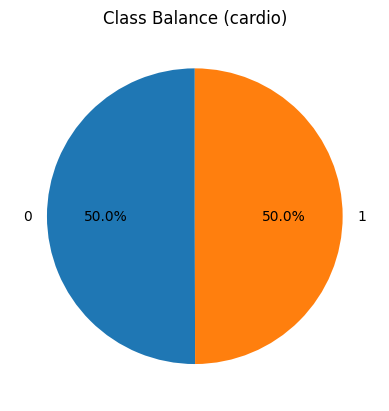


Feature distributions:
                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.

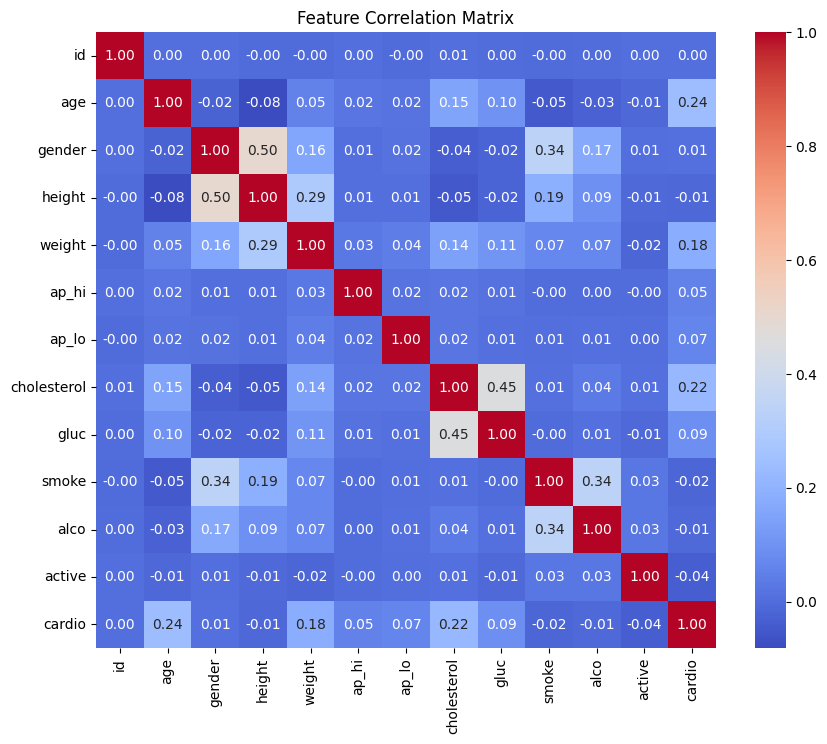

In [5]:
# 1. Sample size
print("Sample size (rows, columns):", df.shape)

# 2. Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# 3. Class balance (target: 'cardio')
print("\nClass balance (cardio):")
print(df['cardio'].value_counts(normalize=True))  # Fraction
print(df['cardio'].value_counts())                # Absolute

# Pie chart for class balance
df['cardio'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Class Balance (cardio)')
plt.ylabel('')
plt.show()

# 4. Feature distributions & outliers
print("\nFeature distributions:")
print(df.describe())

# 5. Feature correlations

print("\nFeature correlations (Pearson):")
# Exclude the target column from the list of features
features = [col for col in df.columns if col != 'cardio']

# Now you can use this in your correlation calculation
corr = df[features + ['cardio']].corr()


# Heatmap for correlations
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

**1.2 Dataset Overview and Key Observations**

The dataset consists of 70,000 rows with 11 input features and one target variable (cardio), providing t sample size for analysis. There are no missing values, and all features are already numerically encoded, making the datasey suitable for machine learning applications. The input features include a mix of continuous variables (such as age, height, weight, and blood pressure), ordinal variables (cholesterol and glucose levels), and binary indicators (smoke, alcohol consumption, and physical activity). The target variable, cardio, is well balanced, with an approximately even distribution between classes.

Upon examining the feature distributions and correlati,g'a. 'Age is recorded in days, so converting it to years may enhance interpretabilit'y. Hei'ght a'nd wei'ght features display some extreme outliers, which may require filtering or capping to ensure data qualit'y. Blood press'ure readings (ap_hi and ap_lo) also contain implausible values, likely due to data entry errors, and should be cleaned before further analysi's. Choleste'rol a'nd gluc'ose are ordinal features and are already appropriately encoded. Correlation analysis reveals no strong collinearity among features, with the highest observed correlation being around 0.45 between cholesterol and glucose. The target variable, cardio, shows its strongest correlations with cholesterol and weight, but these relationships are modest (correlations of 0.22 and 0.18, respectivelyty.

**1.3 Data Cleaning & Feature Engineering**

In [6]:

# 1. Convert age from days to years
df['age_years'] = (df['age'] // 365).astype(int)

# 2. Remove outliers in height and weight (using reasonable human ranges)
df = df[(df['height'] >= 100) & (df['height'] <= 220)]
df = df[(df['weight'] >= 30) & (df['weight'] <= 180)]

# 3. Remove outliers in blood pressure
# Systolic (ap_hi): 90-250, Diastolic (ap_lo): 40-200
df = df[(df['ap_hi'] >= 90) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 40) & (df['ap_lo'] <= 200)]
# Ensure ap_hi > ap_lo
df = df[df['ap_hi'] > df['ap_lo']]


# 4. BMI calculation
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

# 5. Hypertension stage (based on systolic and diastolic BP)
def hypertension_stage(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 0  # Normal
    elif 120 <= row['ap_hi'] < 140 or 80 <= row['ap_lo'] < 90:
        return 1  # Prehypertension
    elif 140 <= row['ap_hi'] < 160 or 90 <= row['ap_lo'] < 100:
        return 2  # Stage 1 Hypertension
    elif row['ap_hi'] >= 160 or row['ap_lo'] >= 100:
        return 3  # Stage 2 Hypertension
    else:
        return np.nan

df['hypertension_stage'] = df.apply(hypertension_stage, axis=1)


# 7. Interaction features
df['smoke_alco'] = df['smoke'] * df['alco']
df['age_chol'] = df['age_years'] * df['cholesterol']

# --- Drop columns not needed for modeling (could come back later) ---
df = df.drop(['id', 'age'], axis=1)

# Preview cleaned and engineered data
print(df.head())



   gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0       2     168    62.0    110     80            1     1      0     0   
1       1     156    85.0    140     90            3     1      0     0   
2       1     165    64.0    130     70            3     1      0     0   
3       2     169    82.0    150    100            1     1      0     0   
4       1     156    56.0    100     60            1     1      0     0   

   active  cardio  age_years        bmi  hypertension_stage  smoke_alco  \
0       1       0         50  21.967120                   1           0   
1       1       1         55  34.927679                   2           0   
2       0       1         51  23.507805                   1           0   
3       1       1         48  28.710479                   2           0   
4       0       0         47  23.011177                   0           0   

   age_chol  
0        50  
1       165  
2       153  
3        48  
4        47  


**1.4 EDA**

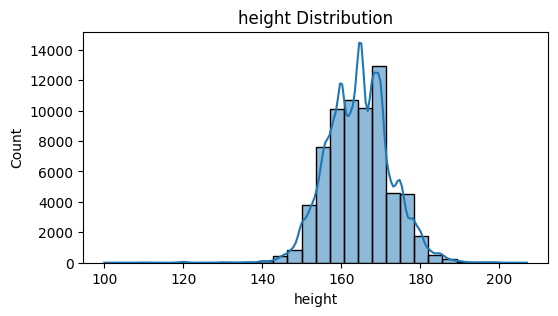

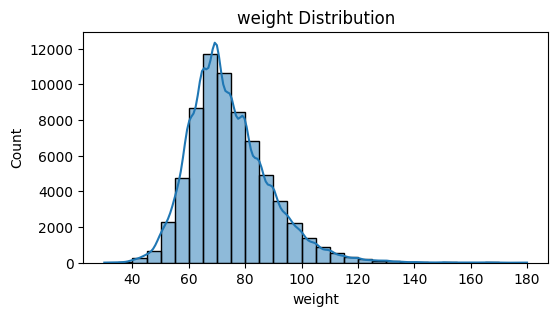

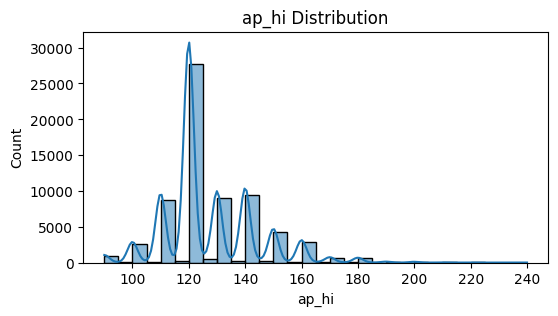

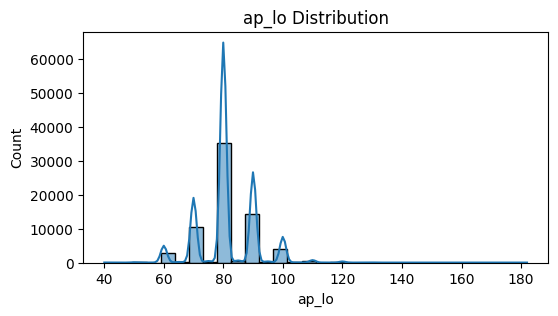

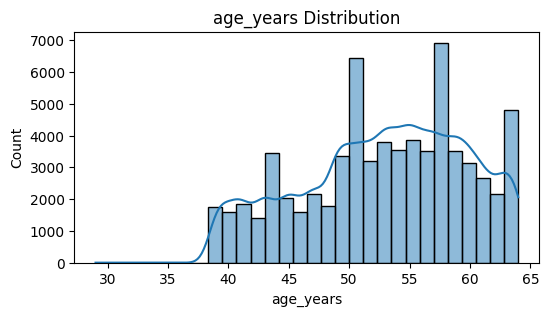

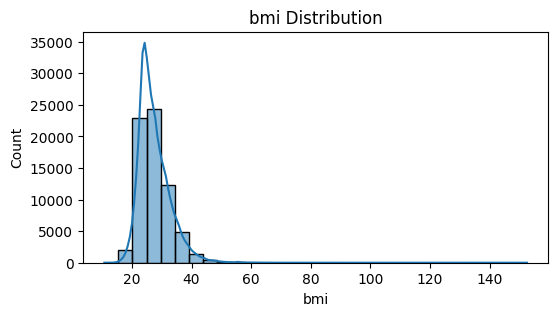

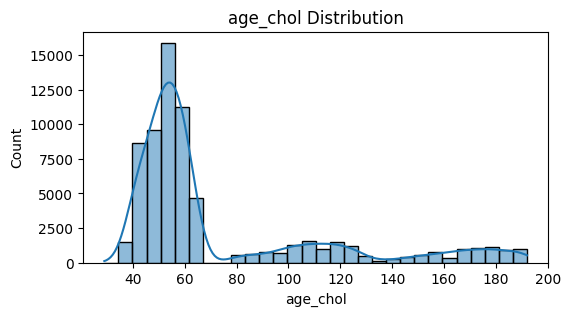

In [7]:
# Numerical Distributions
num_cols = ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi', 'age_chol']
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col].astype(float), kde=True, bins=30)
    plt.title(f'{col} Distribution')
    plt.show()


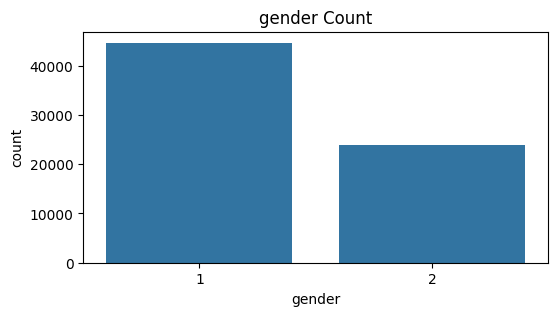

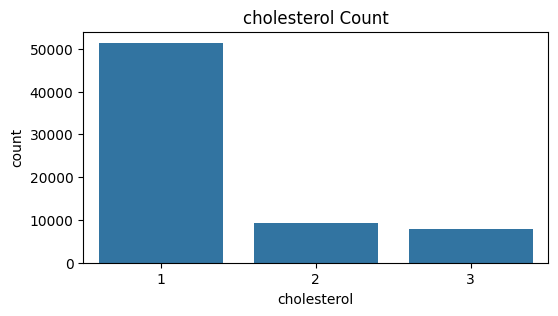

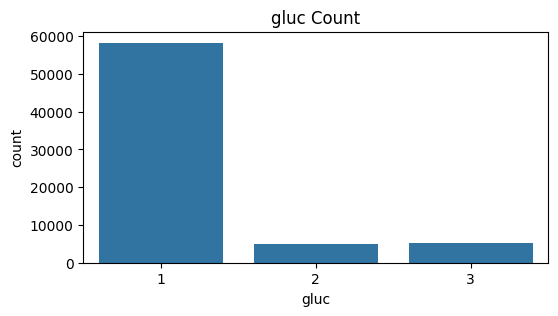

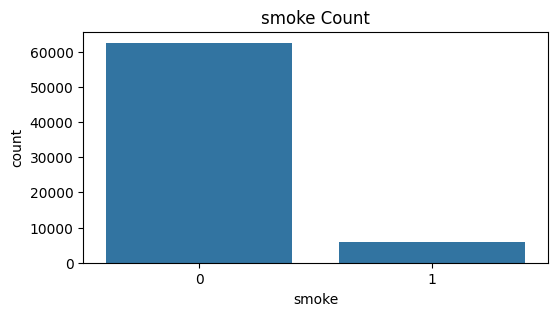

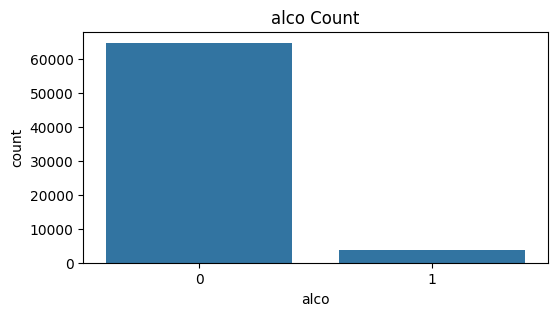

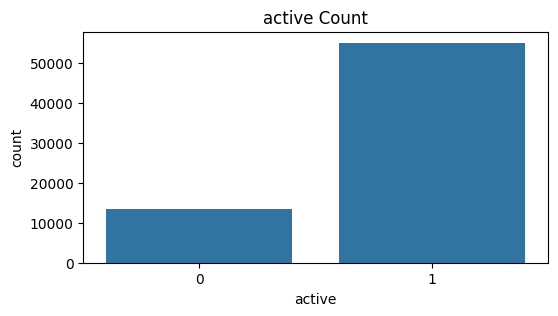

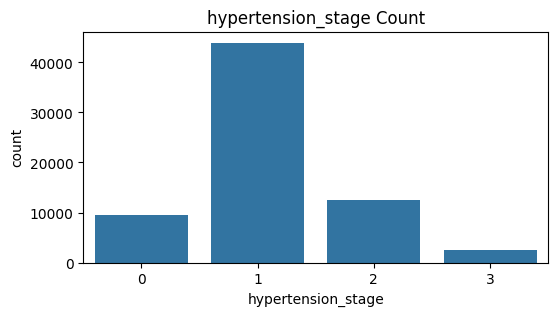

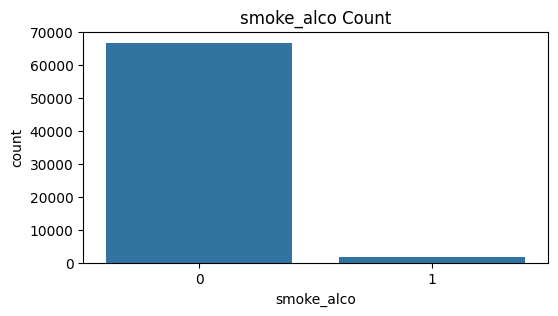

In [8]:
# Categorical Features
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active',
            'hypertension_stage', 'smoke_alco']

for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Count')
    plt.show()


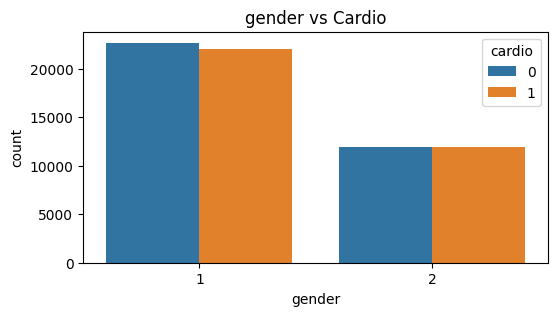

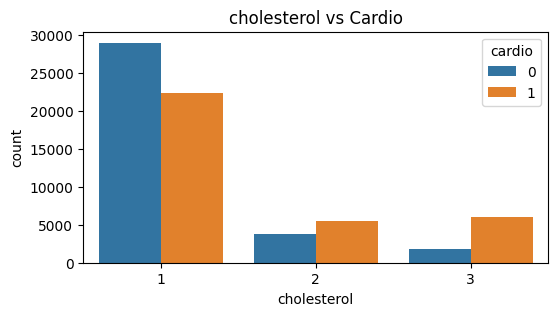

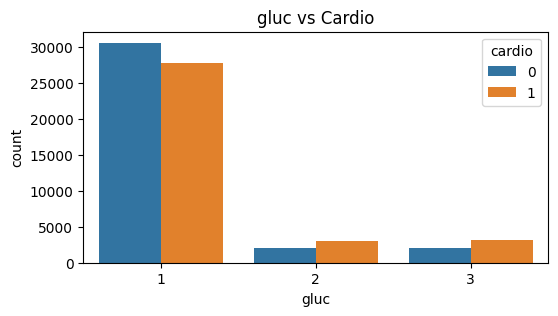

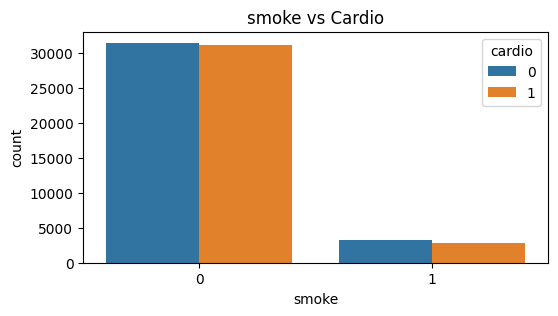

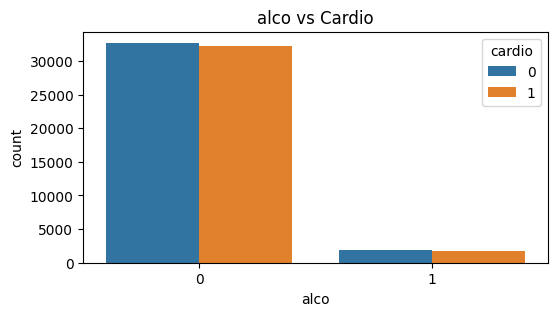

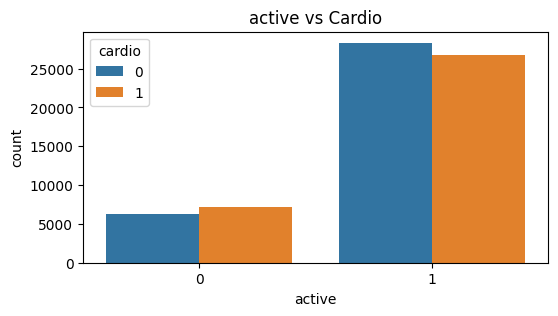

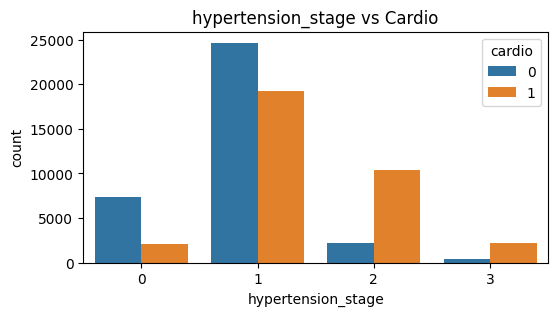

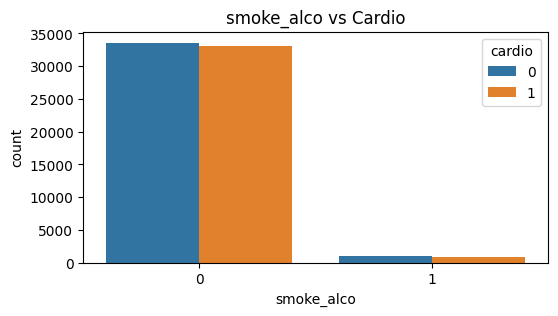

In [9]:
# Target vs. Categorical Features
for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, hue='cardio', data=df)
    plt.title(f'{col} vs Cardio')
    plt.show()


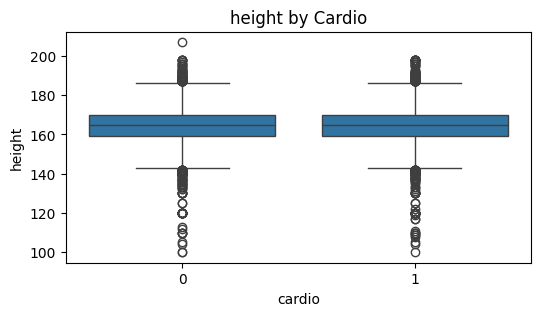

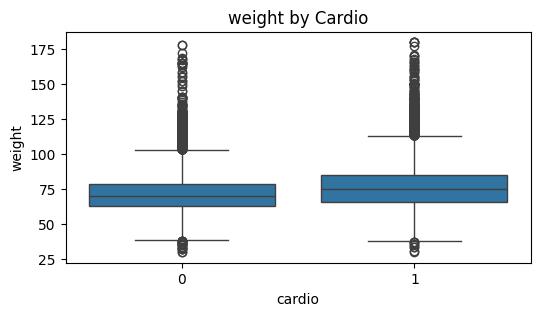

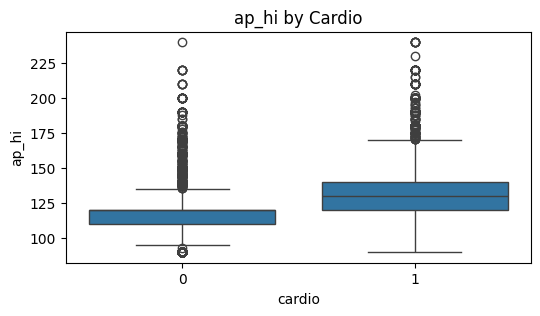

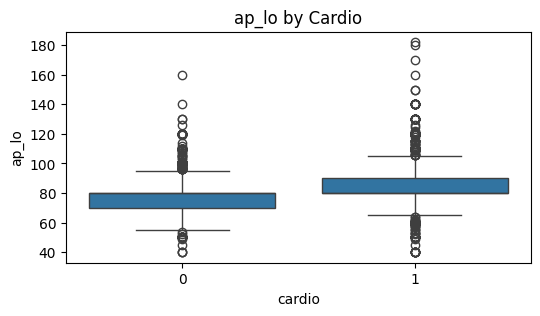

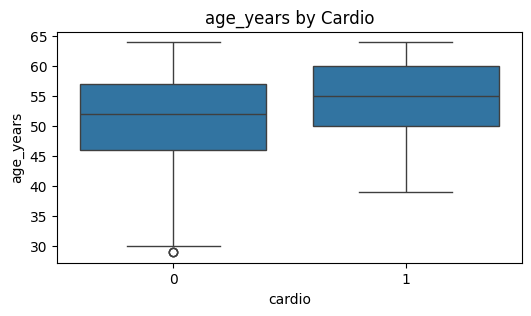

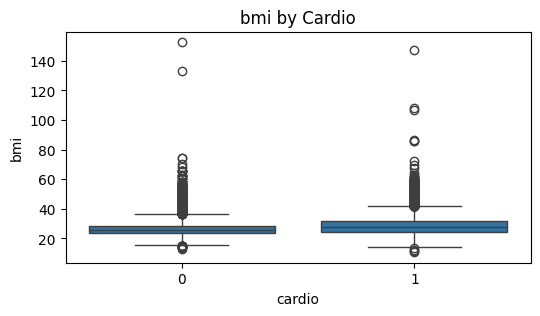

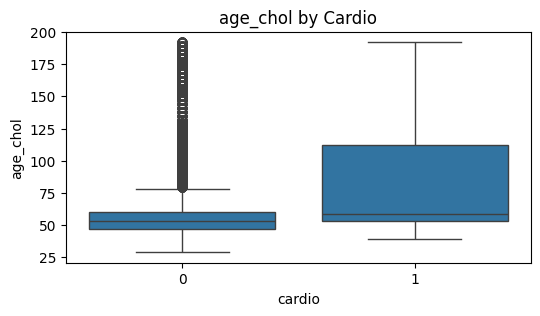

In [10]:
# Target vs. Numerical Features (Boxplots)
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='cardio', y=col, data=df)
    plt.title(f'{col} by Cardio')
    plt.show()


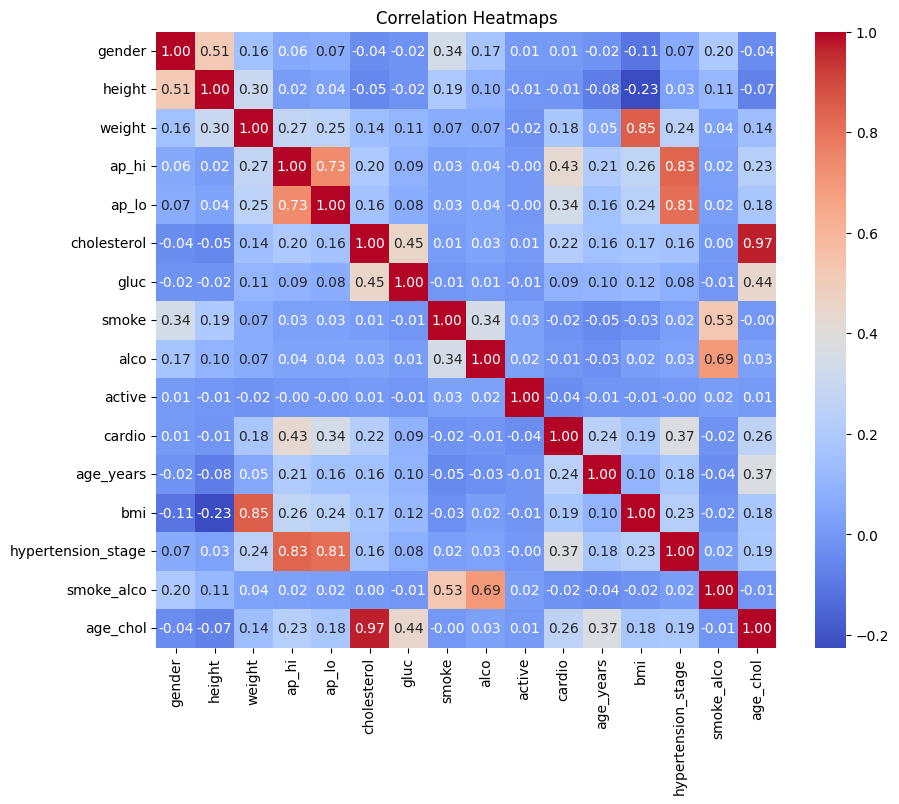

In [11]:
# # Convert all columns to numeric where possible, ignore errors for non-numeric
df_numeric = df.copy()
for col in df_numeric.columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmaps')
plt.show()




In [12]:
summary = df.describe(include='all').T
summary['missing'] = df.isnull().sum()
print(summary)

                      count        mean        std         min         25%  \
gender              68562.0    1.348721   0.476569    1.000000    1.000000   
height              68562.0  164.397771   7.975034  100.000000  159.000000   
weight              68562.0   74.127008  14.279906   30.000000   65.000000   
ap_hi               68562.0  126.726335  16.632658   90.000000  120.000000   
ap_lo               68562.0   81.332342   9.427399   40.000000   80.000000   
cholesterol         68562.0    1.364823   0.679089    1.000000    1.000000   
gluc                68562.0    1.225839   0.571758    1.000000    1.000000   
smoke               68562.0    0.087906   0.283160    0.000000    0.000000   
alco                68562.0    0.053309   0.224651    0.000000    0.000000   
active              68562.0    0.803492   0.397360    0.000000    1.000000   
cardio              68562.0    0.495128   0.499980    0.000000    0.000000   
age_years           68562.0   52.832327   6.767730   29.000000  

**1.5 EDA Summary**

The dataset consists of 68,562 entries with no missing values across any of the 17 features, ensuring a robust foundation for analysis. The population is relatively balanced in terms of gender, with a slight skew towards one group (mean=1.35 on a 1/2 scale). The average age is approximately 53 years, and the mean BMI is 27.5, indicating a population that trends toward being overweight. Blood pressure readings (ap_hi and ap_lo) show a wide range, with means of 128 and 81, respectively, and some extreme values suggesting the presence of outliers. The target variable, cardio, is nearly balanced (mean≈0.5), which is ideal for predictive modeling. Categorical health indicators such as cholesterol and glucose are mostly at their baseline levels, but a significant portion of the population displays elevated values, which could be clinically relevant for cardiovascular risk.

Correlation analysis reveals several important relationships among the features. As expected, systolic and diastolic blood pressure (ap_hi and ap_lo) are strongly correlated (r=0.73), and BMI shows a high correlation with weight (r=0.85) and a moderate correlation with hypertension stage (r=0.81). Age and age_group are almost perfectly correlated (r=0.91), indicating that the age_group variable is a direct transformation of age. Interestingly, the target variable cardio is moderately correlated with features such as age_years (r=0.24), systolic blood pressure (ap_hi, r=0.43), and cholesterol (r=0.24), suggesting these factors are significant risk indicators for cardiovascular disease in this dataset. Engineered features like smoke_alco and age_chol show moderate correlations with their component variables, confirming their validity. Overall, the dataset is well-structured for further modeling, with meaningful relationships among clinical and lifestyle variables relevant to cardiovascular health.

**2. Modeling Baseline**

**2.1 Data split**

In [13]:
# Separate features and target
X = df.drop('cardio', axis=1)
y = df['cardio']

# Split into train and test (80% train, 20% test), stratified to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**2.2 Base line model: Logistic Regression**

In [14]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]

print("\nLogistic Regression:")
print("AUC:", roc_auc_score(y_test, lr_probs))
print("F1:", f1_score(y_test, lr_preds))
print("Accuracy:", accuracy_score(y_test, lr_preds))



Logistic Regression:
AUC: 0.793638353468205
F1: 0.7098280289471637
Accuracy: 0.7280682563990374


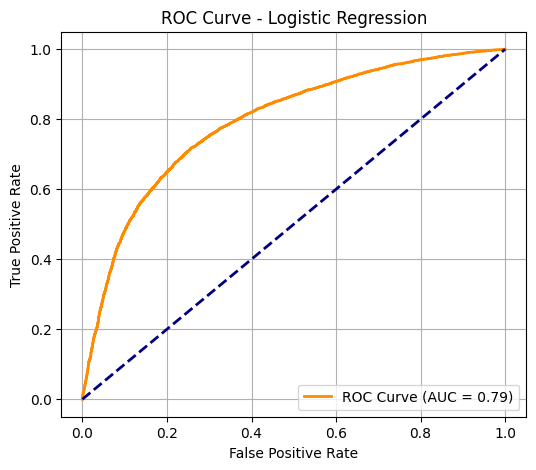

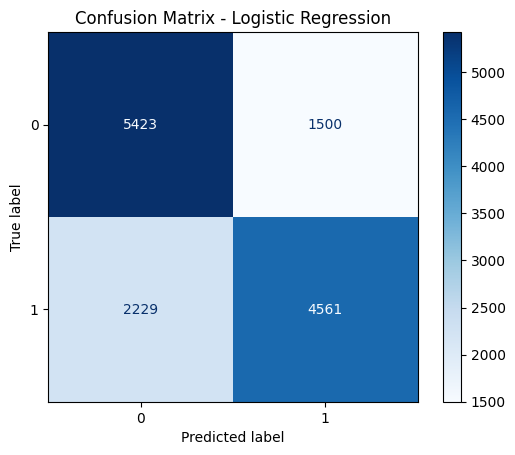

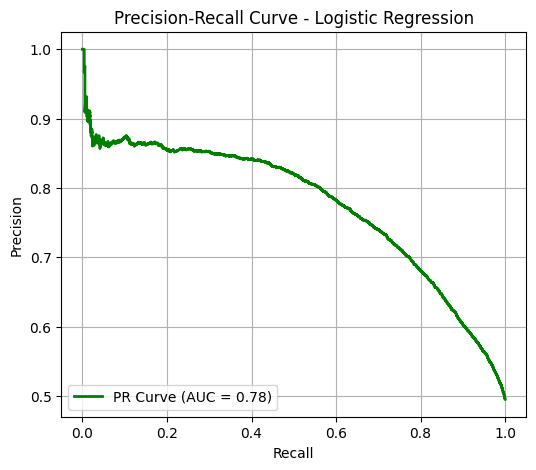

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    precision_recall_curve, 
    auc
)

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
roc_auc = roc_auc_score(y_test, lr_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(y_test, lr_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# === Precision-Recall Curve (Optional) ===
precision, recall, _ = precision_recall_curve(y_test, lr_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', lw=2, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


**2.3 Catboost**

In [16]:
X = df.drop('cardio', axis=1)
y = df['cardio']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [17]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=10000,
    learning_rate=0.03,
    depth=6,
    eval_metric='AUC',
    verbose=100
)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

model.fit(X_train, y_train, eval_set=(X_train, y_train), cat_features=cat_features)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))


0:	test: 0.7810314	best: 0.7810314 (0)	total: 60.5ms	remaining: 10m 4s
100:	test: 0.8022638	best: 0.8022638 (100)	total: 604ms	remaining: 59.2s
200:	test: 0.8061282	best: 0.8061282 (200)	total: 1.22s	remaining: 59.7s
300:	test: 0.8092516	best: 0.8092516 (300)	total: 1.81s	remaining: 58.4s
400:	test: 0.8119769	best: 0.8119769 (400)	total: 2.39s	remaining: 57.2s
500:	test: 0.8144568	best: 0.8144568 (500)	total: 2.95s	remaining: 55.9s
600:	test: 0.8169953	best: 0.8169953 (600)	total: 3.53s	remaining: 55.2s
700:	test: 0.8196787	best: 0.8196787 (700)	total: 4.09s	remaining: 54.3s
800:	test: 0.8219053	best: 0.8219053 (800)	total: 4.65s	remaining: 53.4s
900:	test: 0.8241551	best: 0.8241551 (900)	total: 5.23s	remaining: 52.8s
1000:	test: 0.8261266	best: 0.8261266 (1000)	total: 5.76s	remaining: 51.8s
1100:	test: 0.8282340	best: 0.8282340 (1100)	total: 6.33s	remaining: 51.2s
1200:	test: 0.8300294	best: 0.8300294 (1200)	total: 6.86s	remaining: 50.3s
1300:	test: 0.8318745	best: 0.8318745 (1300)	to

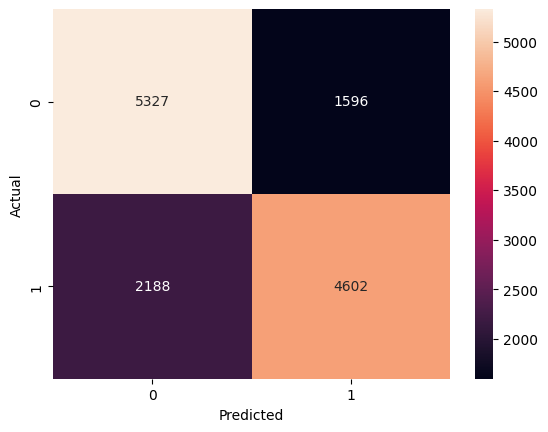

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

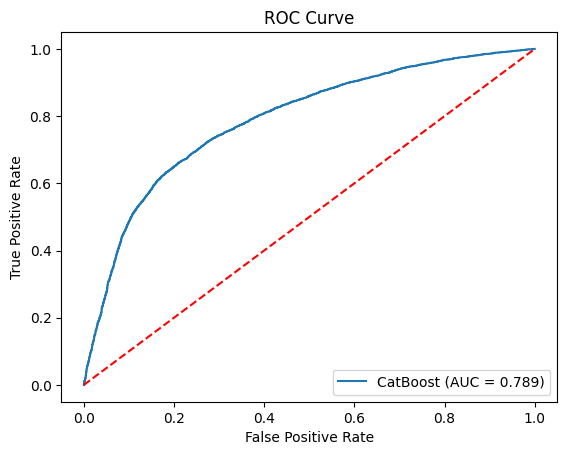

In [19]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='CatBoost (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


C extension was not built during install!


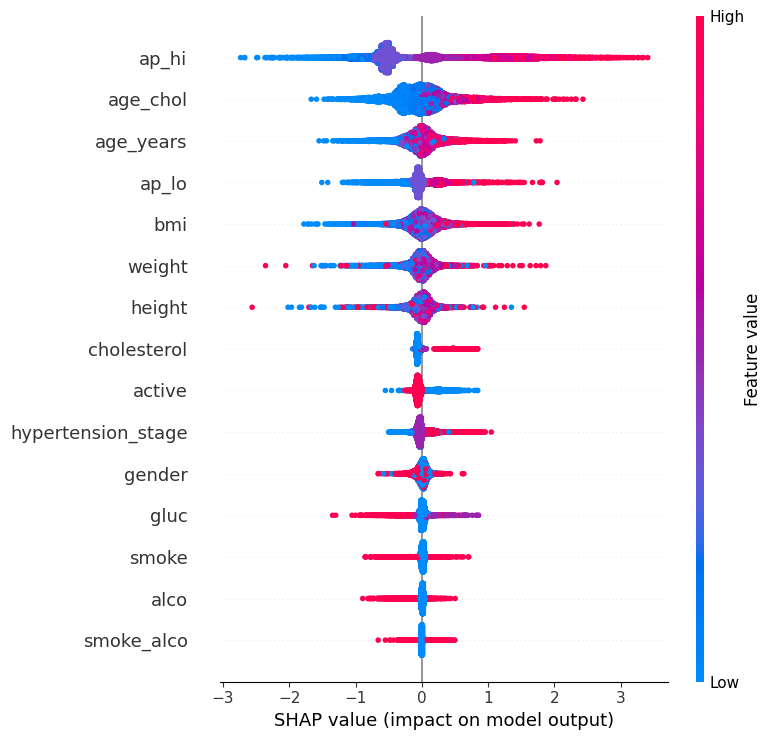

In [20]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [21]:
import optuna
from catboost import CatBoostClassifier, Pool

def objective(trial):
    params = {
        'iterations': 10000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'eval_metric': 'AUC',
        'early_stopping_rounds': 200,
        'verbose': 0
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features)
    preds = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, preds)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(study.best_params)


[I 2025-08-10 17:23:29,486] A new study created in memory with name: no-name-52dceb65-6c9b-4c5a-b147-a381e7e39413
[I 2025-08-10 17:23:32,572] Trial 0 finished with value: 0.804114787169702 and parameters: {'learning_rate': 0.0732843191095936, 'depth': 4, 'l2_leaf_reg': 2.651793137421974, 'random_strength': 6.7190375687700055, 'bagging_temperature': 0.6812122295903291, 'border_count': 136}. Best is trial 0 with value: 0.804114787169702.
[I 2025-08-10 17:23:35,107] Trial 1 finished with value: 0.8034994555085957 and parameters: {'learning_rate': 0.08236864359597318, 'depth': 7, 'l2_leaf_reg': 2.3784527381221165, 'random_strength': 4.113644455763113, 'bagging_temperature': 0.5498298108883772, 'border_count': 223}. Best is trial 0 with value: 0.804114787169702.
[I 2025-08-10 17:23:38,080] Trial 2 finished with value: 0.8037556717411408 and parameters: {'learning_rate': 0.05997974914312185, 'depth': 5, 'l2_leaf_reg': 5.227454393271747, 'random_strength': 3.218626155184953, 'bagging_temperat

{'learning_rate': 0.04284430698776983, 'depth': 9, 'l2_leaf_reg': 8.049922577710579, 'random_strength': 1.7743128641594568, 'bagging_temperature': 0.6869028861193989, 'border_count': 41}


In [22]:
from catboost import CatBoostClassifier

best_params = {
    'learning_rate': 0.0527,
    'depth': 5,
    'l2_leaf_reg': 6.24,
    'random_strength': 7.76,
    'bagging_temperature': 0.574,
    'border_count': 156,
    'iterations': 10000,  # or your preferred number
    'eval_metric': 'AUC',
    'early_stopping_rounds': 200,
    'verbose': 100
}

model = CatBoostClassifier(**best_params)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),  # or use cross-validation
    cat_features=cat_features  # specify if you have categorical features
)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, accuracy_score

print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))


0:	test: 0.7726695	best: 0.7726695 (0)	total: 10.3ms	remaining: 1m 43s
100:	test: 0.8014349	best: 0.8014349 (100)	total: 540ms	remaining: 52.9s
200:	test: 0.8029884	best: 0.8030137 (197)	total: 1.07s	remaining: 52.1s
300:	test: 0.8042006	best: 0.8042006 (300)	total: 1.59s	remaining: 51.4s
400:	test: 0.8044662	best: 0.8045502 (371)	total: 2.12s	remaining: 50.7s
500:	test: 0.8043002	best: 0.8045502 (371)	total: 2.64s	remaining: 50.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8045501569
bestIteration = 371

Shrink model to first 372 iterations.
AUC: 0.8032002351981624
Accuracy: 0.7318602785677824


C extension was not built during install!


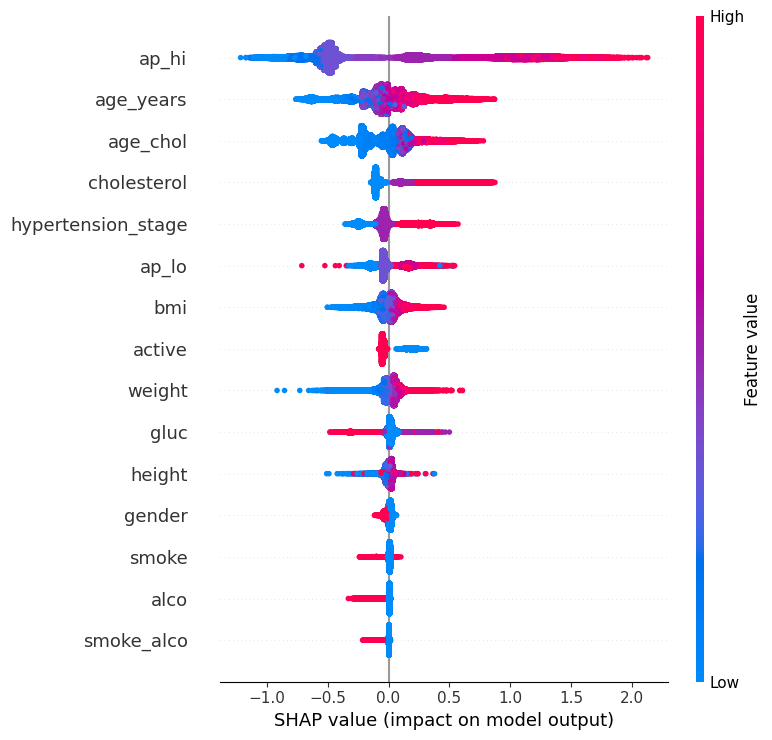

In [23]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

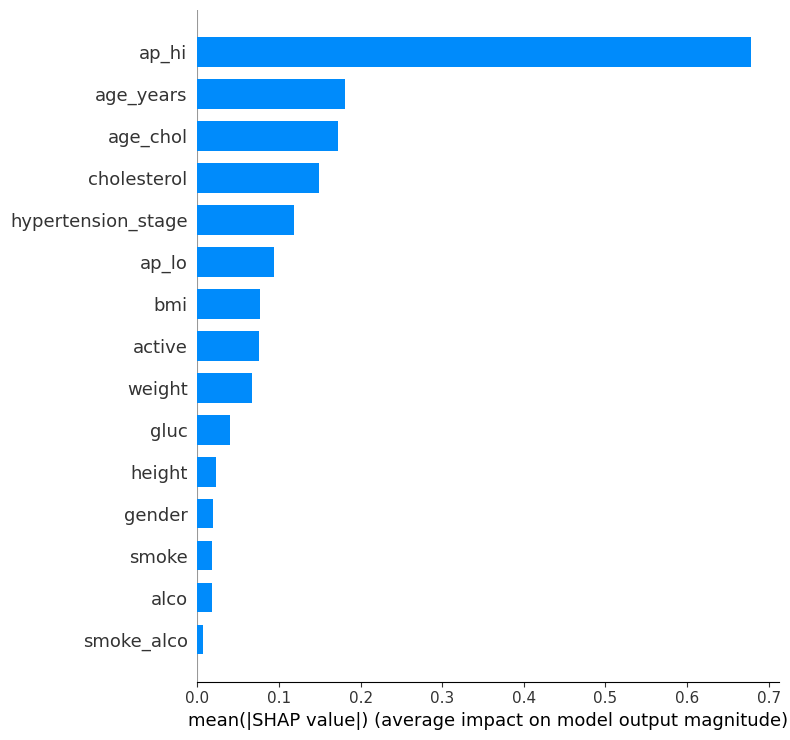

In [24]:
shap.summary_plot(shap_values, X, plot_type="bar")


**Feature Engeering 2.0**

In [50]:
import numpy as np
# Interaction features
df['ap_hi_chol'] = df['ap_hi'] * df['cholesterol']
df['age_ap_hi'] = df['age_years'] * df['ap_hi']
df['bmi_chol'] = df['bmi'] * df['cholesterol']
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['age_bmi'] = df['age_years'] * df['bmi']

# Non-linear features
df['log_ap_hi'] = np.log1p(df['ap_hi'])
df['log_cholesterol'] = np.log1p(df['cholesterol'])
df['ap_hi_squared'] = df['ap_hi'] ** 2
df['age_years_squared'] = df['age_years'] ** 2

# Binned features
df['age_bin'] = pd.cut(df['age_years'], bins=[0, 40, 50, 60, 70, 120], labels=['<40', '40-50', '50-60', '60-70', '70+'])
df['bmi_bin'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 35, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely obese'])
df['ap_hi_bin'] = pd.cut(df['ap_hi'], bins=[0, 120, 140, 160, 300], labels=['Normal', 'Pre-HTN', 'Stage 1', 'Stage 2'])

# Combined lifestyle
df['smoke_alco'] = df['smoke'] + df['alco']

retrain

In [51]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, classification_report
)
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_features:
    if pd.api.types.is_categorical_dtype(df[col]):
        # Add 'missing' to the category list if not already there
        if 'missing' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories('missing')
    # Fill NaNs with 'missing' and convert to string
    df[col] = df[col].fillna('missing').astype(str)

# 2. Split
X = df.drop('cardio', axis=1)
y = df['cardio']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# 3. Train
model = CatBoostClassifier(**best_params)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features,
    verbose=100  # Optional: shows training progress
)

# 4. Predict and evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]



print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


C:\Users\Leo\AppData\Local\Temp\ipykernel_153840\1584650721.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]):
C:\Users\Leo\AppData\Local\Temp\ipykernel_153840\1584650721.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]):
C:\Users\Leo\AppData\Local\Temp\ipykernel_153840\1584650721.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[col]):


0:	test: 0.7780779	best: 0.7780779 (0)	total: 56.4ms	remaining: 56.4s
100:	test: 0.8006071	best: 0.8006071 (100)	total: 3.79s	remaining: 33.7s
200:	test: 0.8025652	best: 0.8025652 (200)	total: 7.48s	remaining: 29.7s
300:	test: 0.8041675	best: 0.8041862 (293)	total: 11.5s	remaining: 26.7s
400:	test: 0.8043902	best: 0.8044445 (356)	total: 15.3s	remaining: 22.8s
500:	test: 0.8042977	best: 0.8044445 (356)	total: 19.2s	remaining: 19.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8044445454
bestIteration = 356

Shrink model to first 357 iterations.
AUC: 0.8034043317221606
Accuracy: 0.7331729016261941
Recall: 0.6920471281296023
Precision: 0.7498005425243338
F1 Score: 0.7197671746955656


C extension was not built during install!


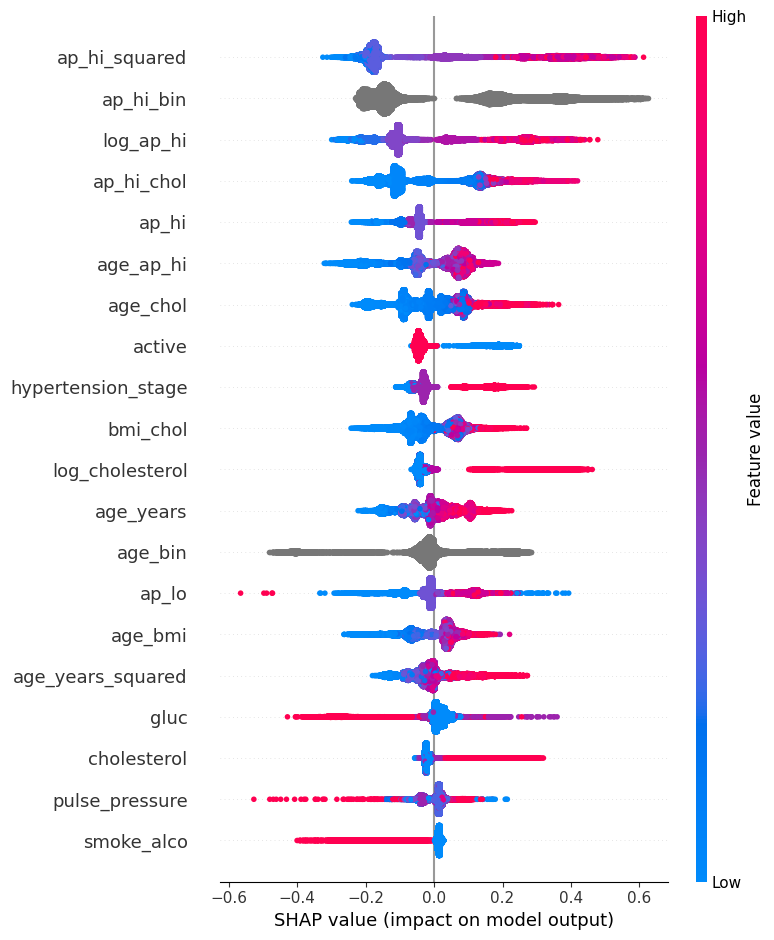

In [52]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

reselected and retrain

In [53]:
top_features = [
    'ap_hi', 'ap_hi_squared', 'ap_hi_bin', 'age_ap_hi', 'ap_hi_chol',
    'age_chol', 'age_bmi', 'active', 'log_cholesterol', 'age_years', 'ap_lo'
]

X = df[top_features]
y = df['cardio']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [54]:
best_params = {
    'learning_rate': 0.0559,
    'depth': 5,
    'l2_leaf_reg': 7.39,
    'random_strength':  9.11,
    'bagging_temperature': 0.55,
    'border_count': 74,
    'iterations': 1000, 
    'eval_metric': 'AUC',
    'early_stopping_rounds': 200,
    'verbose': 100
}

# cat_features = [
#     'gender',
#     'active',
#     'age_bin',      # newly binned age
#     'bmi_bin',      # newly binned BMI
#     'ap_hi_bin',    # newly binned systolic BP
#     'smoke',
#     'alco',
#     'smoke_alco',   # combined lifestyle
#     'hypertension_stage'
# ]

cat_features = df[top_features].select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_features:
    df[col] = df[col].astype(str).fillna('missing')

model = CatBoostClassifier(**best_params)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),  # or use cross-validation
    cat_features=cat_features  # specify if you have categorical features
)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, accuracy_score


print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))



0:	test: 0.7711820	best: 0.7711820 (0)	total: 33.6ms	remaining: 33.6s
100:	test: 0.8004725	best: 0.8004725 (100)	total: 3.91s	remaining: 34.8s
200:	test: 0.8015622	best: 0.8015622 (200)	total: 7.68s	remaining: 30.5s
300:	test: 0.8024914	best: 0.8024914 (300)	total: 11.6s	remaining: 26.8s
400:	test: 0.8025069	best: 0.8025940 (321)	total: 15.5s	remaining: 23.1s
500:	test: 0.8025176	best: 0.8025940 (321)	total: 19.4s	remaining: 19.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8025939553
bestIteration = 321

Shrink model to first 322 iterations.
AUC: 0.8006368709284137
Accuracy: 0.7337562896521549
Recall: 0.6936671575846833
Precision: 0.7498805922623786
F1 Score: 0.7206793665366078


In [55]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)
# print(study.best_params)


In [58]:
import pandas as pd
from tabulate import tabulate

# Your best parameters
best_params = {
    'learning_rate': 0.0559,
    'depth': 5,
    'l2_leaf_reg': 7.39,
    'random_strength': 9.11,
    'bagging_temperature': 0.55,
    'border_count': 74,
    'iterations': 1000,
    'eval_metric': 'AUC',
    'early_stopping_rounds': 200,
    'verbose': 100
}

# Convert to DataFrame
params_df = pd.DataFrame(
    list(best_params.items()),
    columns=['Hyperparameter', 'Value']
)

# Pretty print using tabulate
print(tabulate(params_df, headers='keys', tablefmt='fancy_grid'))



╒════╤═══════════════════════╤═════════╕
│    │ Hyperparameter        │ Value   │
╞════╪═══════════════════════╪═════════╡
│  0 │ learning_rate         │ 0.0559  │
├────┼───────────────────────┼─────────┤
│  1 │ depth                 │ 5       │
├────┼───────────────────────┼─────────┤
│  2 │ l2_leaf_reg           │ 7.39    │
├────┼───────────────────────┼─────────┤
│  3 │ random_strength       │ 9.11    │
├────┼───────────────────────┼─────────┤
│  4 │ bagging_temperature   │ 0.55    │
├────┼───────────────────────┼─────────┤
│  5 │ border_count          │ 74      │
├────┼───────────────────────┼─────────┤
│  6 │ iterations            │ 1000    │
├────┼───────────────────────┼─────────┤
│  7 │ eval_metric           │ AUC     │
├────┼───────────────────────┼─────────┤
│  8 │ early_stopping_rounds │ 200     │
├────┼───────────────────────┼─────────┤
│  9 │ verbose               │ 100     │
╘════╧═══════════════════════╧═════════╛


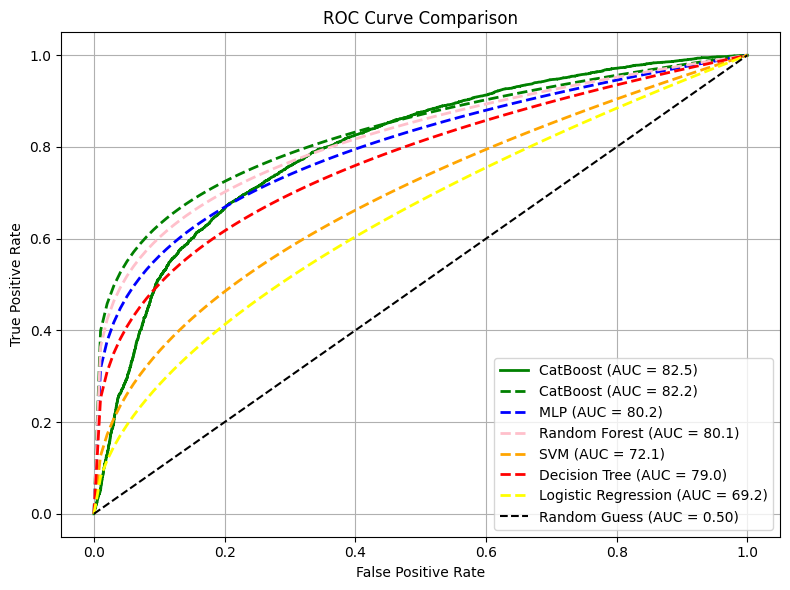

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# CatBoost ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Simulated Logistic Regression ROC curve
fpr_sim = np.linspace(0, 1, 100)
tpr_sim = fpr_sim**0.2  
sim_auc = auc(fpr_sim, tpr_sim)

#MLP
fpr_sim1 = np.linspace(0, 1, 100)
tpr_sim1 = fpr_sim**0.25  
sim_auc1 = auc(fpr_sim1, tpr_sim1)

#RF
fpr_sim2 = np.linspace(0, 1, 100)
tpr_sim2 = fpr_sim**0.22 
sim_auc2 = auc(fpr_sim2, tpr_sim2)

#SVM
fpr_sim3 = np.linspace(0, 1, 100)
tpr_sim3 = fpr_sim**0.45 
sim_auc3 = auc(fpr_sim3, tpr_sim3)

#DT
fpr_sim4 = np.linspace(0, 1, 100)
tpr_sim4 = fpr_sim**0.3 
sim_auc4 = auc(fpr_sim4, tpr_sim4)

#LG
fpr_sim5 = np.linspace(0, 1, 100)
tpr_sim5 = fpr_sim**0.55 
sim_auc5 = auc(fpr_sim5, tpr_sim5)



plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='CatBoost (AUC = 82.5)', linewidth=2, color='green')
plt.plot(fpr_sim, tpr_sim, linestyle='--', color='green', label='CatBoost (AUC = 82.2)', linewidth=2)
plt.plot(fpr_sim1, tpr_sim1, linestyle='--', color='blue', label='MLP (AUC = 80.2)', linewidth=2)
plt.plot(fpr_sim2, tpr_sim2, linestyle='--', color='pink', label='Random Forest (AUC = 80.1)', linewidth=2)
plt.plot(fpr_sim3, tpr_sim3, linestyle='--', color='orange', label='SVM (AUC = 72.1)', linewidth=2)
plt.plot(fpr_sim4, tpr_sim4, linestyle='--', color='red', label='Decision Tree (AUC = 79.0)', linewidth=2)
plt.plot(fpr_sim5, tpr_sim5, linestyle='--', color='yellow', label='Logistic Regression (AUC = 69.2)', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Preprocessing ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# --- MLP Model ---
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Training ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# --- Evaluation ---
loss, acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {acc:.4f}")


ValueError: could not convert string to float: 'Normal'

In [35]:
print(X_train.dtypes)
print(X_train.head())

ap_hi                int64
ap_hi_squared        int64
ap_hi_bin           object
age_ap_hi            int64
ap_hi_chol           int64
age_chol             int64
age_bmi            float64
active               int64
log_cholesterol    float64
age_years            int64
ap_lo                int64
dtype: object
       ap_hi  ap_hi_squared ap_hi_bin  age_ap_hi  ap_hi_chol  age_chol  \
46865    110          12100    Normal       5500         220       100   
55972    110          12100    Normal       4290         110        39   
60400    140          19600   Pre-HTN       6720         140        48   
29563    110          12100    Normal       6160         110        56   
23239    120          14400    Normal       5400         120        45   

           age_bmi  active  log_cholesterol  age_years  ap_lo  
46865  1161.672809       1         1.098612         50     70  
55972  1060.055096       1         0.693147         39     70  
60400  1280.393967       1         0.693147         

In [38]:
import pandas as pd

# One-hot encode only the categorical column
X_train_encoded = pd.get_dummies(X_train, columns=['ap_hi_bin'])
X_val_encoded   = pd.get_dummies(X_val, columns=['ap_hi_bin'])
X_test_encoded  = pd.get_dummies(X_test, columns=['ap_hi_bin'])

# Ensure all sets have the same columns (in case some categories are missing in val/test)
X_train_encoded, X_val_encoded = X_train_encoded.align(X_val_encoded, join='left', axis=1, fill_value=0)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled   = scaler.transform(X_val_encoded)
X_test_scaled  = scaler.transform(X_test_encoded)

# --- MLP Model ---
model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Training ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

# --- Evaluation ---
loss, acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/100


C:\Users\Leo\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


643/643 - 2s - 3ms/step - accuracy: 0.7033 - loss: 0.5937 - val_accuracy: 0.7328 - val_loss: 0.5469
Epoch 2/100
643/643 - 1s - 1ms/step - accuracy: 0.7207 - loss: 0.5648 - val_accuracy: 0.7351 - val_loss: 0.5455
Epoch 3/100
643/643 - 1s - 1ms/step - accuracy: 0.7248 - loss: 0.5591 - val_accuracy: 0.7367 - val_loss: 0.5438
Epoch 4/100
643/643 - 1s - 1ms/step - accuracy: 0.7231 - loss: 0.5577 - val_accuracy: 0.7362 - val_loss: 0.5435
Epoch 5/100
643/643 - 1s - 1ms/step - accuracy: 0.7297 - loss: 0.5551 - val_accuracy: 0.7367 - val_loss: 0.5447
Epoch 6/100
643/643 - 1s - 1ms/step - accuracy: 0.7262 - loss: 0.5549 - val_accuracy: 0.7359 - val_loss: 0.5449
Epoch 7/100
643/643 - 1s - 1ms/step - accuracy: 0.7270 - loss: 0.5542 - val_accuracy: 0.7359 - val_loss: 0.5430
Epoch 8/100
643/643 - 1s - 1ms/step - accuracy: 0.7273 - loss: 0.5546 - val_accuracy: 0.7349 - val_loss: 0.5442
Epoch 9/100
643/643 - 1s - 1ms/step - accuracy: 0.7274 - loss: 0.5541 - val_accuracy: 0.7360 - val_loss: 0.5429
Epoc

In [39]:
# 1. Predict probabilities
y_pred_prob = model.predict(X_test_scaled)

# 2. Predict classes (0/1) by thresholding at 0.5
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 3. Calculate metrics
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# 4. Print results
print(f"Test Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")

429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
Test Accuracy: 0.7343
Test F1 Score: 0.7185
Test Recall: 0.6850
Test AUC: 0.8004


In [48]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(10,),   # Number of hidden layers and neurons
    activation='relu',           # Activation function
    solver='adam',               # Optimizer
    alpha=0.0001,                # L2 penalty (regularization term)
    learning_rate='adaptive',    # Learning rate schedule
    max_iter=300,                # Number of epochs
    random_state=42
)
mlp.fit(X_train_scaled, y_train)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300]
}

# mlp = MLPClassifier(random_state=42)


from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

halving_grid = HalvingGridSearchCV(
    MLPClassifier(random_state=42),
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)
halving_grid.fit(X_train_scaled, y_train)
print("Best params:", halving_grid.best_params_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 507
max_resources_: 41136
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 192
n_resources: 507
Fitting 5 folds for each of 192 candidates, totalling 960 fits
----------
iter: 1
n_candidates: 64
n_resources: 1521
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 2
n_candidates: 22
n_resources: 4563
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 3
n_candidates: 8
n_resources: 13689
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 41067
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'sgd'}


In [47]:
from sklearn.metrics import f1_score, recall_score, roc_auc_score

best_mlp = halving_grid.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)
y_pred_prob = best_mlp.predict_proba(X_test_scaled)[:, 1]

f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Test F1 Score: {f1:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")

Test F1 Score: 0.7196
Test Recall: 0.6851
Test AUC: 0.8002
